## Plot puv fluxes (baroclinic and barotropic energy)
adapted from plot_BclinNRJ_subdomains.ipynb

Plot time series e.g. low-pass filtered fields or avg.


In [22]:
%matplotlib notebook
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
#plt.rcParams['text.usetex'] = True
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset, MFDataset
import numpy as np
import gsw
from scipy.ndimage import gaussian_filter
from PIL import Image, ImageDraw
import json

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

In [23]:
simul = 'luckyt'
if simul == "luckyt":
    sea = "_win"
else:
    sea = ""
nambc = "bclnrj" #"puv_fluxes_hf" #"puv_fluxes"
nambt = "btrnrj" #"bt_fluxes" # 

nambc += sea
nambt += sea

path_base = KRYPTON + 'DIAG/NRJ_fluxes/'
fil_iflux = path_base+simul+'_{}.?.nc'.format(nambc) #'_puv_fluxes_hf.?.nc'#
fil_sflux = path_base+simul+'_{}.?.nc'.format(nambt)
fil_grd = KRYPTON + 'lucky_corgrd.nc'
st = 2  #ncr.subsamp_step
pm, pn = (1/(st*750),)*2 # a la main but should be read in file for more generality

units = {"ekint":r"kJ/m$^2$", "flux":r"kw/m", "cterm":r"W/m$^2$",
        "divf":r"W/m$^2$", "dissip":r"W/m$^2$"}
vnam = {key:key for key in ["ekint", "flux", "cterm", "divf", "dissip"]}
vnam["cterm"] = r"$C_t$"
vnam["ekint"] = r"$E_k$"

#plotting parameters
dirpic = './pictures/NRJ_evol/'
dosavefig = False


In [24]:
# Load data: grid & topo & subdomains
doploth = True  # plot topo 

ncg = Dataset(fil_grd,'r')
slix = slice(1,2000,st)
sliy = slice(1,2000,st)
fcor = ncg.variables['f'][sliy,:][:,slix]
lon = ncg.variables['lon_rho'][sliy,:][:,slix]
lat = ncg.variables['lat_rho'][sliy,:][:,slix]
dx = .5*(np.mean(1./ncg.variables['pm'][:]) + np.mean(1./ncg.variables['pn'][:]) ) * st
Ny, Nx = lon.shape
j1, j2, i1, i2 = 0, Ny, 0, Nx
topo = ncg.variables['h'][sliy,:][:,slix][j1:j2,i1:i2]
lon = lon[j1:j2,i1:i2]
lat = lat[j1:j2,i1:i2]
ny, nx = lon.shape
print("loaded grid")

# load subdomains
with open("subdomains_lucky.json", "r") as fp:
    mydoms = json.load(fp)

print("min/max lon, lat:", lon.min(), lon.max(), lat.min(), lat.max())

# local routines
def coord_to_pix(pos, lon=lon, lat=lat):
    return np.unravel_index(((lon-pos[0])**2+(lat-pos[1])**2).argmin(), lon.shape)[::-1]

def poly_to_mask(poly,shape):
    img = Image.new('1',shape)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

def polycoord_tomask(coord,lon,lat):
    poly = [coord_to_pix(item) for item in coord]
    return poly_to_mask(poly,lon.shape)

def get_domean(field, dom, lon=lon, lat=lat, masksup=(topo>100)):
    mask = polycoord_tomask(dom, lon, lat)
    if masksup is not None: mask *= masksup
    return np.nanmean(field[...,mask], axis=(-1))

loaded grid
min/max lon, lat: -41.8086236619 -23.2006244309 30.4960379447 44.2189371832


In [34]:
suf = "_lf"

def loadvar(var,ncbc, j1=j1, j2=j2, i1=i1, i2=i2):
    return np.nanmean(ncbc.variables[var][j1:j2,...][:,i1:i2,...], axis=(0,1))

### load data
print("loading", end="... ")
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
if "scrum_time" in ncbc.variables:
    try:
        unit = ncbc.variables['scrum_time'].units
        t2h = 1. if unit=="h" else 1./3600.
    except:
        t2h = 1./3600.
    times = ncbc.variables['scrum_time'][:]*t2h
elif "time" in ncbc.variables:
    times = ncbc.variables['time'][:]
else:
    times = np.arange(ncbc.dimensions['time'].size) + 18366.
    print("no time found in file")

var = "ekint"
print(var, end=", ")
ekint = loadvar(var+suf,ncbc)
var = "epint"
print(var, end=", ")
epint = loadvar(var+suf,ncbc)

ncbc.close()

print("Cterm and btrop NRJ")
ncbt = MFDataset(fil_sflux,aggdim='eta_rho')
cterm = loadvar("Ct"+suf,ncbt)
ekbt = loadvar('ekbt'+suf,ncbt)
epbt = loadvar('epbt'+suf,ncbt)
timeb = ncbt.variables['scrum_time'][:]
ncbt.close()

print("finished")

loading... no time found in file
ekint, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


epint, Cterm and btrop NRJ
finished


In [26]:
times/24

array([  0.        ,   0.04166667,   0.08333333,   0.125     ,
         0.16666667,   0.20833333,   0.25      ,   0.29166667,
         0.33333333,   0.375     ,   0.41666667,   0.45833333,
         0.5       ,   0.54166667,   0.58333333,   0.625     ,
         0.66666667,   0.70833333,   0.75      ,   0.79166667,
         0.83333333,   0.875     ,   0.91666667,   0.95833333,
         1.        ,   1.04166667,   1.08333333,   1.125     ,
         1.16666667,   1.20833333,   1.25      ,   1.29166667,
         1.33333333,   1.375     ,   1.41666667,   1.45833333,
         1.5       ,   1.54166667,   1.58333333,   1.625     ,
         1.66666667,   1.70833333,   1.75      ,   1.79166667,
         1.83333333,   1.875     ,   1.91666667,   1.95833333,
         2.        ,   2.04166667,   2.08333333,   2.125     ,
         2.16666667,   2.20833333,   2.25      ,   2.29166667,
         2.33333333,   2.375     ,   2.41666667,   2.45833333,
         2.5       ,   2.54166667,   2.58333333,   2.62

In [27]:
# compute div flux

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
print("bclin fluxes", end=", ")
fxout = ncbc.variables["puint"+suf][j1:j2,...][:,[i1,i2-1],:]
fyout = ncbc.variables["pvint"+suf][[j1,j2-1],...][:,i1:i2,:]
fxavg = ncbc.variables["puint_avg"][j1:j2,:][:,i1:i2]
fyavg = ncbc.variables["pvint_avg"][j1:j2,:][:,i1:i2]
divfbc = (np.gradient(fxavg, axis=1)/dx + np.gradient(fyavg, axis=0)/dx)*1e3
fbcout = (np.diff(fxout, axis=1).squeeze().sum(axis=0)/nx \
        + np.diff(fyout, axis=0).squeeze().sum(axis=0)/ny) /dx
ncbc.close()

print("btrop fluxes")
ncbt = MFDataset(fil_sflux,aggdim='eta_rho')
fxout = ncbt.variables["pubt"+suf][j1:j2,...][:,[i1,i2-1],:]
fyout = ncbt.variables["pvbt"+suf][[j1,j2-1],...][:,i1:i2,:]
fxavg = ncbt.variables["pubt_avg"][j1:j2,:][:,i1:i2]
fyavg = ncbt.variables["pvbt_avg"][j1:j2,:][:,i1:i2]
divfbt = (np.gradient(fxavg, axis=1)/dx + np.gradient(fyavg, axis=0)/dx)*1e3
fbtout = (np.diff(fxout, axis=1).squeeze().sum(axis=0)/nx \
        + np.diff(fyout, axis=0).squeeze().sum(axis=0)/ny) /dx
ncbt.close()

print("finished")
del fxavg, fyavg, fxout, fyout

# check result
print("bclin: int(divf), sum(fout):", np.nanmean(divfbc), fbcout.mean())
print("btrop: int(divf), sum(fout):", np.nanmean(divfbt), fbtout.mean())

bclin fluxes, 

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


btrop fluxes


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


finished
bclin: int(divf), sum(fout): 0.000885243 0.00090571
btrop: int(divf), sum(fout): 0.00214343 0.00226826


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


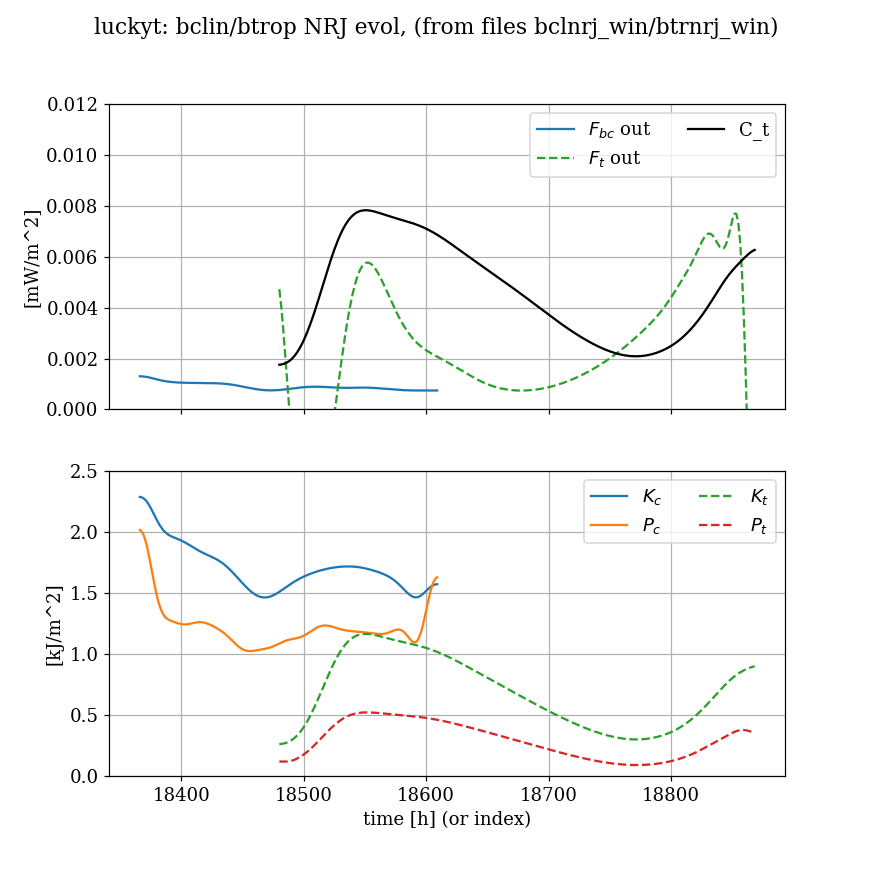

In [35]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
ax = axs[0]
#ax.plot(times, divfbc, label=r"$\nabla F_c$")
ax.plot(times, fbcout, label=r"$F_{bc}$ out")
#ax.plot(times, divfbt, "--", label=r"$\nabla F_t$")
ax.plot(timeb, fbtout, "--", label=r"$F_t$ out", color="tab:green")
ax.plot(timeb, cterm, "k", label="C_t")
ax.set_ylim([0, 1.2e-2])
ax.legend(ncol=2)
ax.set_ylabel('[mW/m^2]')

ax = axs[1]
ax.plot(times, ekint, label=r"$K_c$")
ax.plot(times, epint, label=r"$P_c$")
ax.plot(timeb, ekbt, "--", label=r"$K_t$")
ax.plot(timeb, epbt, "--", label=r"$P_t$")
ax.set_ylim([0, 2.5])
ax.legend(ncol=2)
ax.set_ylabel('[kJ/m^2]')

for ax in axs:
    ax.grid(True)
axs[1].set_xlabel('time [h] (or index)')
fig.suptitle('{0}: bclin/btrop NRJ evol, (from files {1}/{2})'.format(simul,nambc,nambt))

if dosavefig:
    fig.savefig(dirpic+"{0}_btbcNRJ_evol_{1}-{2}.pdf".format(simul,nambc.rstrip(sea),nambt) \
                , magnification="auto", bbox_inches="tight")

<IPython.core.display.Javascript object>


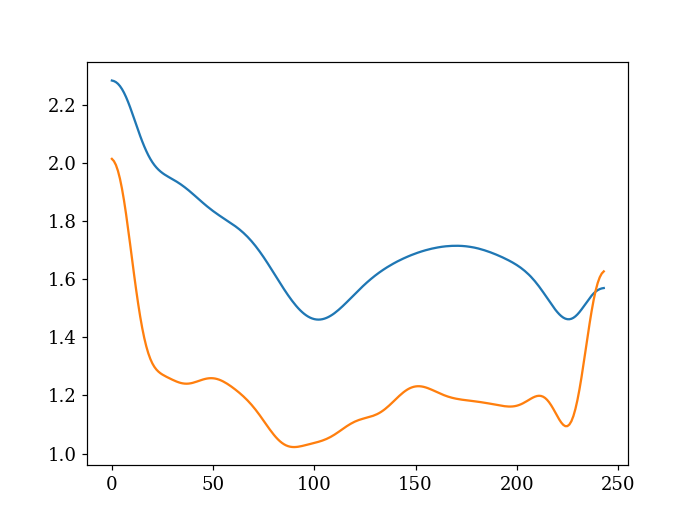

In [21]:
fig = plt.figure()
ax = plt.gca()
ax.plot(times, ekint, label=r"$K_c$")
ax.plot(times, epint, label=r"$P_c$")

<IPython.core.display.Javascript object>


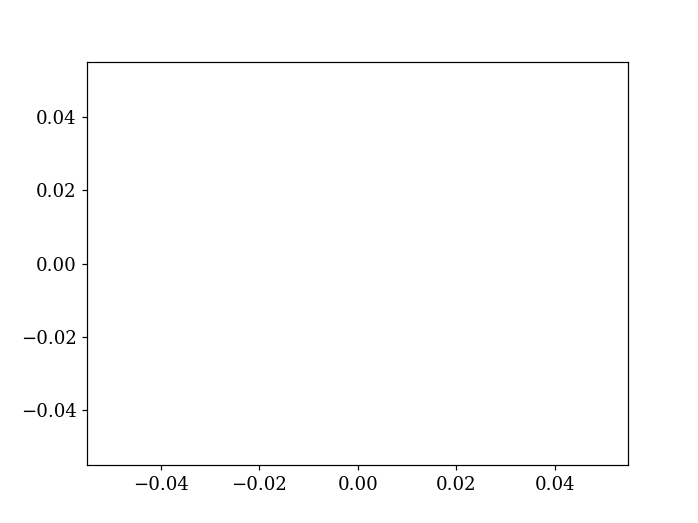

In [19]:
plt.figure()
plt.plot(cterm)

In [11]:
fig.savefig(dirpic+"{0}_btbcNRJ_evol_{1}-{2}.pdf".format(simul,nambc.rstrip(sea),nambt) \
                , magnification="auto", bbox_inches="tight")

In [9]:
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
puint = ncbc.variables['puint'][:]
ncbc.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


<IPython.core.display.Javascript object>


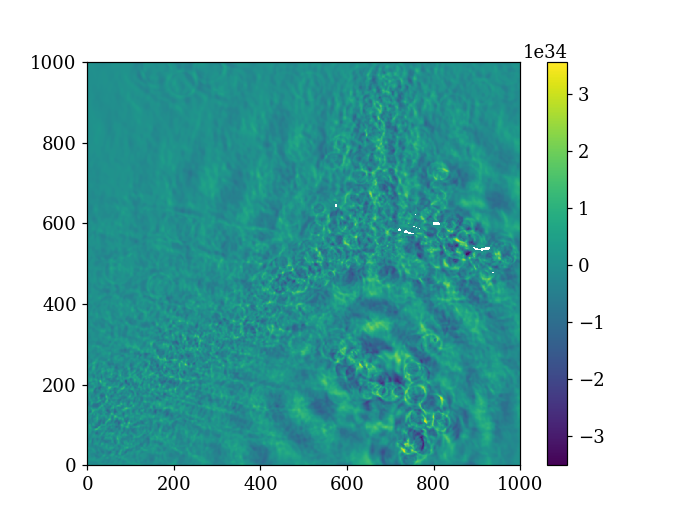

In [15]:
plt.figure()
plt.pcolormesh(puint[:,:,100])
plt.colorbar()

## Time evolution (from previous notebook)
of integrated quantities

In [21]:
# Per subdomain (ct, diss and U_bt only) !
ress = {}

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
if 'scrum_time' in ncbc.variables:
    times = ncbc.variables['scrum_time'][:]/24
else:
    times = np.arange(Nt)/24.
prov = (np.gradient(ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:], axis=1)/dx \
        + np.gradient(ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:], axis=0)/dx)*1e3
ncbc.close()

for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam] = {"divf":np.nanmean(prov[mask,:], axis=0)}

# conversion and btrop KE
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
prov = ncbt.variables['Ct_lf'][j1:j2,:,:][:,i1:i2,:]
ncbt.close()
for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam]["cterm"] = np.nanmean(prov[mask,:], axis=0)
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")    
prov = np.sqrt(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:]*2)
ncbt.close()
for nam,dom in zip(nams,doms):
    mask = polycoord_tomask(dom, lon, lat) * (topo>100)
    ress[nam]["Ubt"] = np.nanmean(prov[mask,:], axis=0)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


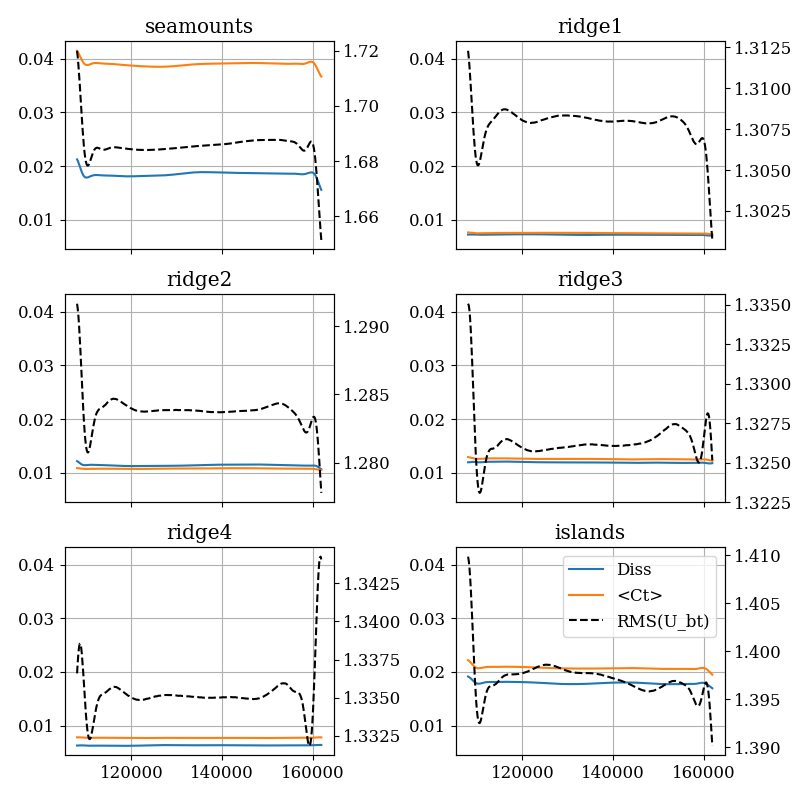

In [23]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(8,8))

# conversion, dissipation
for ia in range(len(doms)):
    ax = axs.ravel()[ia]
    dom, nam = doms[ia], nams[ia]
    ax.plot(times, ress[nam]["cterm"]-ress[nam]["divf"], label="Diss")
    ax.plot(times, ress[nam]["cterm"], label="<Ct>")
    bx = ax.twinx()
    bx.plot(times, ress[nam]["Ubt"], "--k", label="RMS(U_bt)")
    ax.set_title(nam)
for ax in axs.ravel():
    ax.grid(True)
#ax.set_ylabel("Ct and Flux")
#bx.set_ylabel("U_bt")
#ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

fig.set_tight_layout(True)
#fig.suptitle(simul.upper()+': time series of horizontal mean')


In [24]:
# load data (Integrated NRJ and flux, and generation/divergence/dissipation)

ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
if 'scrum_time' in ncbc.variables:
    times = ncbc.variables['scrum_time'][:]/24
else:
    times = np.arange(Nt)/24.
    
ekmean = np.nanmean(ncbc.variables['ekint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
epmean = np.nanmean(ncbc.variables['epint_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
flmean = np.nanmean(np.sqrt((ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]**2 \
                  + ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]**2)), axis=(0,1))
ncbc.close()

# conversion, div flux and dissipation
# load div flux
ncbc = MFDataset(fil_iflux,aggdim='eta_rho')
Nt = ncbc.dimensions['time'].size
fubc = ncbc.variables['puint_lf'][j1:j2,:,:][:,i1:i2,:]
fvbc = ncbc.variables['pvint_lf'][j1:j2,:,:][:,i1:i2,:]
ncbc.close()
divf = np.nanmean(fubc[:,-1,:] - fubc[:,0,:], axis=0)/Nx/dx + np.nanmean(fvbc[-1,:,:] - fvbc[0,:,:], axis=0)/Ny/dx

# conversion and btrop KE
ncbt = MFDataset(fil_sflux, aggdim="eta_rho")
cterm = np.nanmean(ncbt.variables['Ct_lf'][j1:j2,:,:][:,i1:i2,:], axis=(0,1))
ekbt = np.nanmean(np.sqrt(ncbt.variables["ekbt_lf"][j1:j2,:,:][:,i1:i2,:]*2), axis=(0,1))
ncbt.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid

<IPython.core.display.Javascript object>


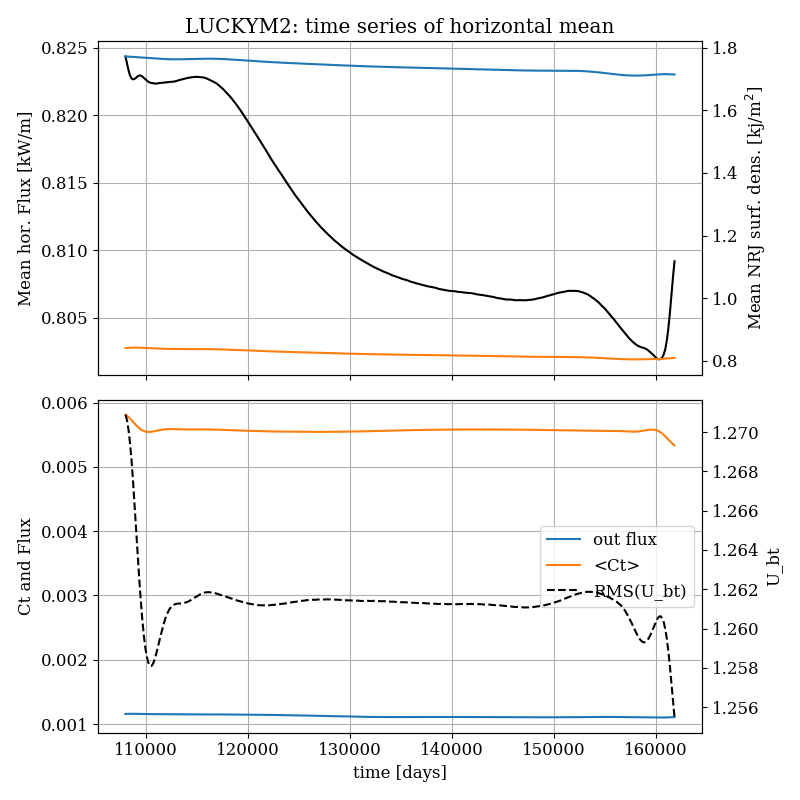

In [25]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,8))
# NRJ (and flux) horizontal mean
ax = axs[0]
ax.plot(times, flmean, "k", label="Flux")
ax.set_ylabel(r'Mean hor. Flux [kW/m]')

axb = plt.twinx(ax)
axb.plot(times, ekmean, label="KE")
axb.plot(times, epmean, label="PE")
axb.set_ylabel(r'Mean NRJ surf. dens. [kj/m$^2$]')

# conversion, dissipation
ax = axs[1]
ax.plot(times, divf*1e3, label="out flux")
ax.plot(times, cterm, label="<Ct>")
bx = ax.twinx()
bx.plot(times, ekbt, "--k", label="RMS(U_bt)")
ax.grid(True)
ax.set_ylabel("Ct and Flux")
bx.set_ylabel("U_bt")
ax.set_xlabel('time [day]')

lina, laba = ax.get_legend_handles_labels()
linb, labb = bx.get_legend_handles_labels()
ax.legend(lina+linb, laba+labb, loc="best")

for ax in axs:
    ax.grid(True)
ax.set_xlabel('time [days]')

axs[0].set_title(simul.upper()+': time series of horizontal mean')
fig.set_tight_layout(True)

if dosavefig:
    fig.savefig(dirpic+simul+"_MeanBclinNRJ_tseries.pdf", magnification="auto", bbox_inches="tight")